In [6]:
!pip install pybids

In [7]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator

data_dir = 'C:/Users/ZY/Dropbox/Dartbrains/Data/localizer'
layout = BIDSLayout(data_dir, derivatives=True)

In [10]:
def load_bids_events(layout, subject):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, scope='raw', suffix='bold')[0].path).shape[-1]

    onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
    onsets.columns = ['Onset', 'Duration', 'Stim']
    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)

dm = load_bids_events(layout, 'S01')
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_computation        128 non-null    float64
 1   horizontal_checkerboard  128 non-null    float64
 2   audio_right_hand         128 non-null    float64
 3   audio_sentence           128 non-null    float64
 4   video_right_hand         128 non-null    float64
 5   audio_left_hand          128 non-null    float64
 6   video_left_hand          128 non-null    float64
 7   vertical_checkerboard    128 non-null    float64
 8   audio_computation        128 non-null    float64
 9   video_sentence           128 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


In [11]:
dm.head()
#use the .head() method to just post the first few rows.

,video_computation,horizontal_checkerboard,audio_right_hand,audio_sentence,video_right_hand,audio_left_hand,video_left_hand,vertical_checkerboard,audio_computation,video_sentence
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

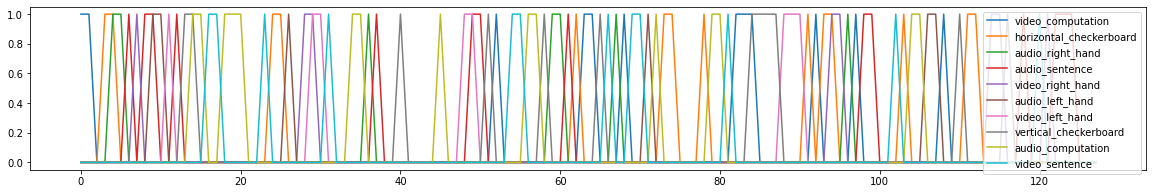

In [12]:
#plot each regressor’s time course
f,a = plt.subplots(figsize=(20,3))
dm.plot(ax=a)

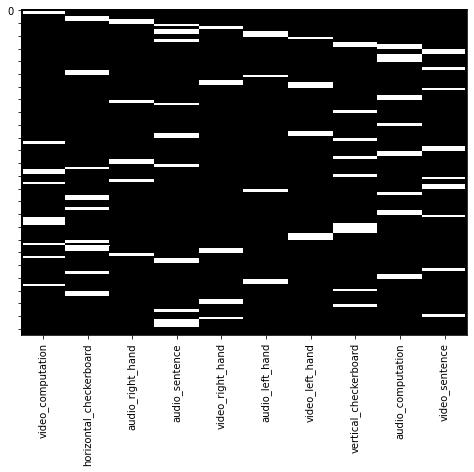

In [13]:
dm.heatmap()
#provides a more useful visual representation of the design matrix.

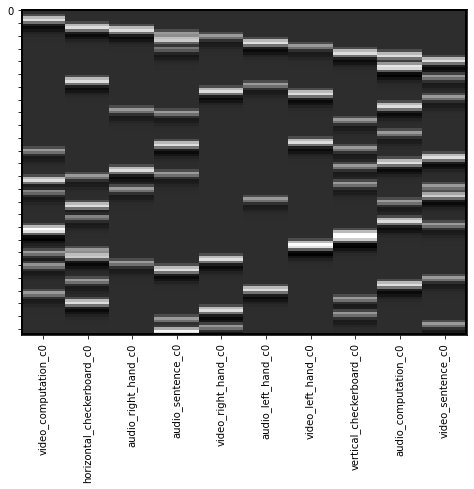

In [14]:
dm_conv = dm.convolve()
dm_conv.heatmap()
#convolve all of the onset regressors with an HRF function

<AxesSubplot:>

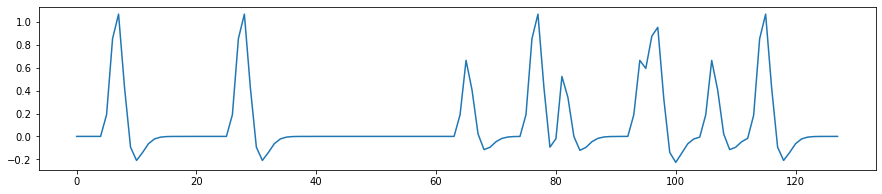

In [15]:
f,a = plt.subplots(figsize=(15,3))
dm_conv['horizontal_checkerboard_c0'].plot(ax=a)

<AxesSubplot:>

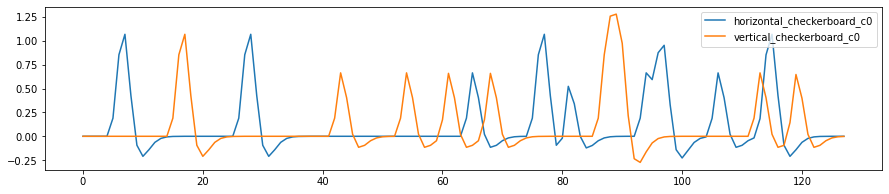

In [16]:
f,a = plt.subplots(figsize=(15,3))
dm_conv[['horizontal_checkerboard_c0','vertical_checkerboard_c0']].plot(ax=a)

<AxesSubplot:>

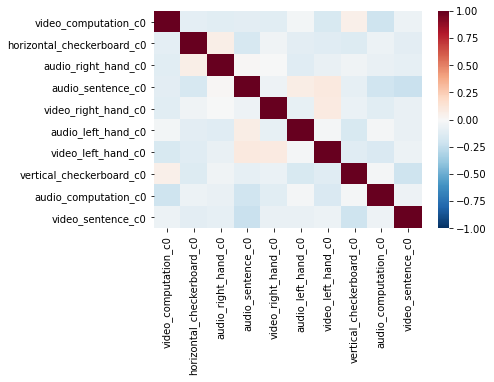

In [17]:
sns.heatmap(dm_conv.corr(), vmin=-1, vmax=1, cmap='RdBu_r')
#evaluate multicollinearity is to examine the pairwise correlations between each regressor.

Text(0, 0.5, 'Variance Inflation Factor')

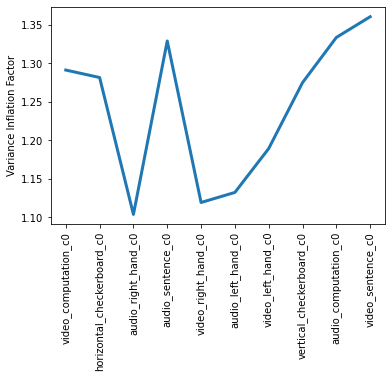

In [18]:
plt.plot(dm_conv.columns, dm_conv.vif(), linewidth=3)
plt.xticks(rotation=90)
plt.ylabel('Variance Inflation Factor')

<AxesSubplot:>

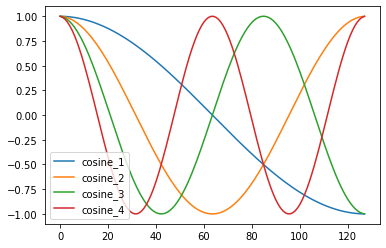

In [19]:
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt.iloc[:,10:].plot()

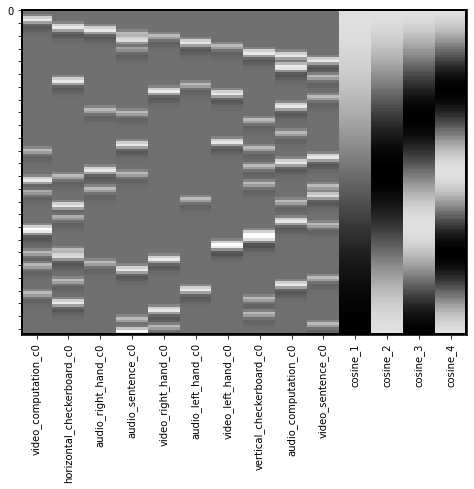

In [20]:
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt.heatmap()

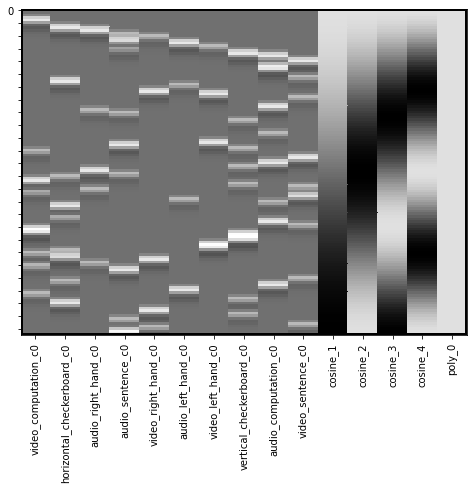

In [21]:
dm_conv_filt_poly = dm_conv_filt.add_poly()
dm_conv_filt_poly.heatmap()

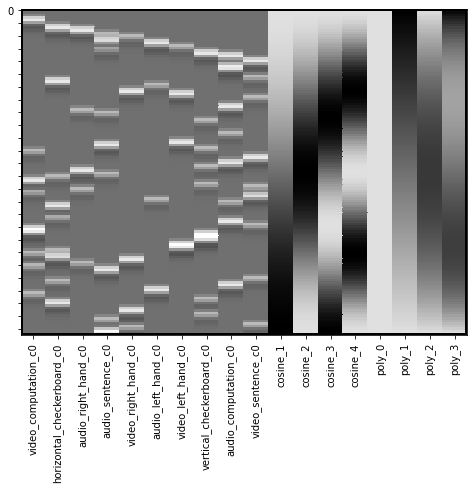

In [22]:
dm_conv_filt_poly = dm_conv_filt.add_poly(order=3, include_lower=True)
dm_conv_filt_poly.heatmap()

#Noise Covariates

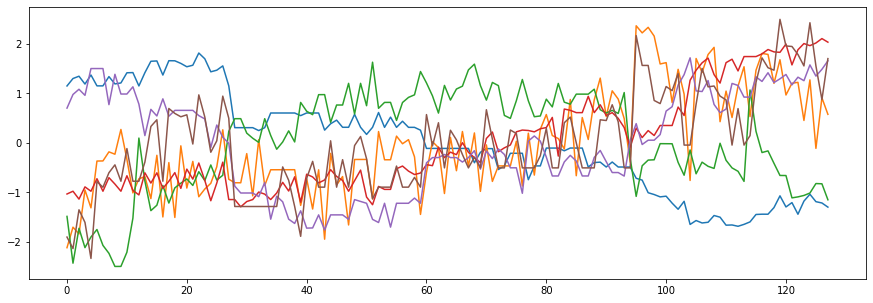

In [25]:
#These pertain to how much each volume had to be moved in the (X,Y,Z) planes and rotations around each axis. 
#standardizing the data so that rotations and translations are on the same scale.
sub = 'S01'
data = Brain_Data(layout.get(subject=sub, task='localizer', scope='derivatives', suffix='bold', extension='nii.gz', return_type='file'))
covariates = pd.read_csv(layout.get(subject='S01', scope='derivatives', extension='.tsv')[0].path, sep='\t')

mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]

plt.figure(figsize=(15,5))
plt.plot(zscore(mc))

<AxesSubplot:>

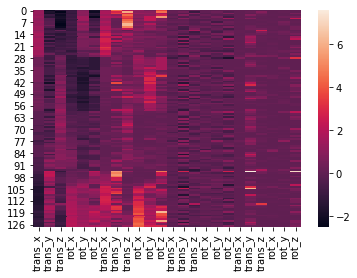

In [26]:
#build the 24 covariates related to head motion

def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

tr = layout.get_tr()
mc_cov = make_motion_covariates(mc, tr)

sns.heatmap(mc_cov)

Text(0, 0.5, 'Intensity')

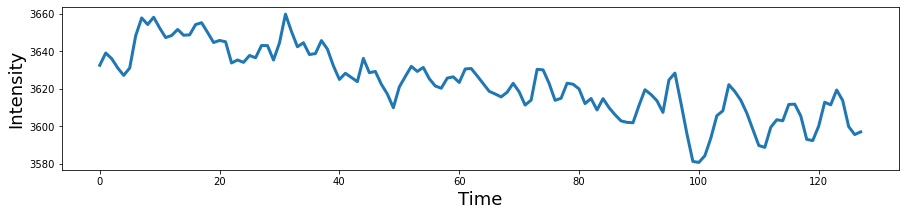

In [27]:
# plot the average signal intensity across all voxels over time.
plt.figure(figsize=(15,3))
plt.plot(np.mean(data.data, axis=1), linewidth=3)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

<AxesSubplot:>

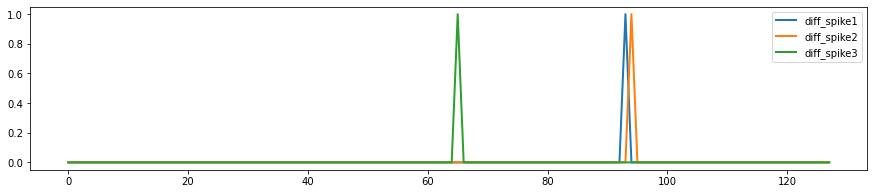

In [28]:
spikes = data.find_spikes(global_spike_cutoff=2.5, diff_spike_cutoff=2.5)

f, a = plt.subplots(figsize=(15,3))
spikes = Design_Matrix(spikes.iloc[:,1:], sampling_freq=1/tr)
spikes.plot(ax = a, linewidth=2)

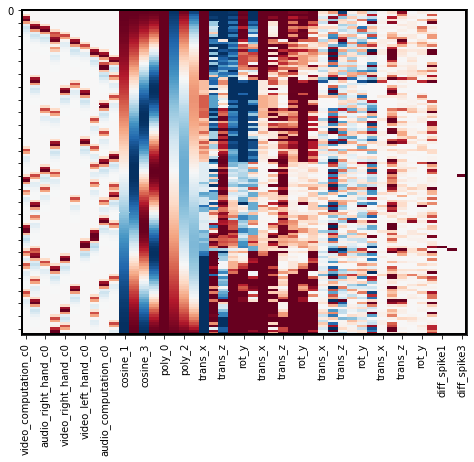

In [29]:
#append each of these additional matrices to our main design matrix.
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, mc_cov, spikes], axis=1)
dm_conv_filt_poly_cov.heatmap(cmap='RdBu_r', vmin=-1,vmax=1)

#Smoothing

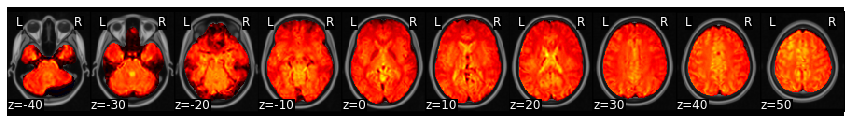

In [30]:
#convolve the image with a 3-D gaussian kernel, with a 6mm full width half maximum (FWHM) using the .smooth() method.
fwhm=6
smoothed = data.smooth(fwhm=fwhm)
data.mean().plot()
#threshold is ignored for simple axial plots

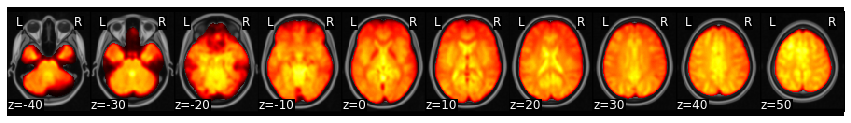

In [31]:
smoothed.mean().plot()
#threshold is ignored for simple axial plots

#Estimate GLM for all voxels

In [32]:
smoothed.X = dm_conv_filt_poly_cov
stats = smoothed.regress()

print(stats.keys())

dict_keys(['beta', 't', 'p', 'sigma', 'residual'])


In [33]:
print(smoothed.X.columns)

Index(['video_computation_c0', 'horizontal_checkerboard_c0',
       'audio_right_hand_c0', 'audio_sentence_c0', 'video_right_hand_c0',
       'audio_left_hand_c0', 'video_left_hand_c0', 'vertical_checkerboard_c0',
       'audio_computation_c0', 'video_sentence_c0', 'cosine_1', 'cosine_2',
       'cosine_3', 'cosine_4', 'poly_0', 'poly_1', 'poly_2', 'poly_3',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x',
       'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y',
       'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'diff_spike1', 'diff_spike2', 'diff_spike3'],
      dtype='object')


In [34]:
stats['beta'][0].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [35]:
smoothed.write(f'{sub}_betas_denoised_smoothed{fwhm}_preprocessed_fMRI_bold.nii.gz')

In [ ]:
#Contrasts

In [36]:
print(smoothed.X.columns)

c1 = np.zeros(len(stats['beta']))
c1[[2,4,5,6]] = 1/4
print(c1)

motor = stats['beta'] * c1

motor.iplot()

Index(['video_computation_c0', 'horizontal_checkerboard_c0',
       'audio_right_hand_c0', 'audio_sentence_c0', 'video_right_hand_c0',
       'audio_left_hand_c0', 'video_left_hand_c0', 'vertical_checkerboard_c0',
       'audio_computation_c0', 'video_sentence_c0', 'cosine_1', 'cosine_2',
       'cosine_3', 'cosine_4', 'poly_0', 'poly_1', 'poly_2', 'poly_3',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x',
       'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y',
       'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'diff_spike1', 'diff_spike2', 'diff_spike3'],
      dtype='object')
[0.   0.   0.25 0.   0.25 0.25 0.25 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.  ]


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [37]:
#which regions are more active when making motor movements with our right hand compared to our left hand.
c_rvl = np.zeros(len(stats['beta']))
c_rvl[[2,4,5,6]] = [.5, .5, -.5, -.5]

motor_rvl = stats['beta'] * c_rvl

motor_rvl.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…